In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt

from haversine import haversine
#from datetime import datetime

In [2]:
# import datasets: every month individually

df_jan = pd.read_csv("data/Taxi_Trips.csv")
df_feb = pd.read_csv("data/Taxi_Trips-2.csv")
df_mar = pd.read_csv("data/Taxi_Trips-3.csv")
df_apr = pd.read_csv("data/Taxi_Trips-4.csv")
df_may = pd.read_csv("data/Taxi_Trips-5.csv")
df_jun = pd.read_csv("data/Taxi_Trips-6.csv")
df_jul = pd.read_csv("data/Taxi_Trips-7.csv")
df_aug = pd.read_csv("data/Taxi_Trips-8.csv")
df_sept = pd.read_csv("data/Taxi_Trips-9.csv")
df_oct = pd.read_csv("data/Taxi_Trips-10.csv")
df_nov = pd.read_csv("data/Taxi_Trips-11.csv")
df_dec = pd.read_csv("data/Taxi_Trips-12.csv")

In [3]:
# combining the dataframes to one (for the whole year)

df_chicago = pd.concat([df_jan,df_feb,df_mar,df_apr,df_may,df_jun,df_jul,df_aug,df_sept,
           df_oct,df_nov,df_dec], axis=0)

In [4]:
df_chicago = df_chicago.reset_index(drop = True)

In [5]:
df_chicago.columns = df_chicago.columns.str.strip().str.replace(' ','_')

In [6]:
# change type of Trip_Start_Timestamp and Trip_End_Timestamp to datetime object

df_chicago['Trip_Start_Timestamp'] = pd.to_datetime(df_chicago['Trip_Start_Timestamp'])
df_chicago['Trip_End_Timestamp'] = pd.to_datetime(df_chicago['Trip_End_Timestamp'])

In [7]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27217716 entries, 0 to 27217715
Data columns (total 24 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Trip_Total                  float64       
 15  Payment_Type                object        
 16  Company         

## Begin cleaning the dataframe: `df_chicago`

# welche NaNs droppen? weil alle wären 16 mio?

### General:

In [8]:
len(df_chicago)-len(df_chicago.dropna())

16969511

In [9]:
print(f"Number of duplicated rows: {len(df_chicago)-len(df_chicago.drop_duplicates(keep=False))}")

Number of duplicated rows: 0


In [10]:
# check if there are duplicated Trip_ID's

print(f"Number of duplicated Trips ID's: {df_chicago.duplicated(subset=['Trip_ID']).sum()}")

Number of duplicated Trips ID's: 0


### `Trip_Miles` and `Trip_Seconds`:

In [11]:
print(f"Number of null values (NaN) in column 'Trip_Miles': {len(df_chicago['Trip_Miles'])-len(df_chicago['Trip_Miles'].dropna())}")
print(f"Number of null values (NaN) in column 'Trip_Seconds': {len(df_chicago['Trip_Seconds'])-len(df_chicago['Trip_Seconds'].dropna())}")

Number of null values (NaN) in column 'Trip_Miles': 208
Number of null values (NaN) in column 'Trip_Seconds': 1127793


In [12]:
df_chicago.dropna(subset=['Trip_Miles','Trip_Seconds'], inplace = True)

Below we check for trips which have negative or zero miles and trips which have a duration of less than a minute:

In [13]:
miles_ = (df_chicago['Trip_Miles'] <= 0).sum()
seconds_ = (df_chicago['Trip_Seconds'] < 60).sum()
print(miles_)
print(seconds_)

10922943
1353082


In [14]:
df_chicago = df_chicago[df_chicago['Trip_Miles'] > 0]
df_chicago = df_chicago[df_chicago['Trip_Seconds'] >= 60]

In [15]:
df_chicago.reset_index(drop = True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,eda829a425ca1da13e1130c700c876881e26ff9a,b47c583b142d75b42882975eaab19c6cb98d8268601657...,2013-01-01 00:00:00,2013-01-01 00:15:00,600.0,3.0,NaN,NaN,NaN,NaN,...,9.65,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0c2b3705c9748a5949bf5b7d727b2d1f2e18805f,c2280976049b22e58ce53a17263114616be76981b9ac56...,2013-01-01 00:00:00,2013-01-01 00:30:00,1320.0,12.3,NaN,NaN,NaN,NaN,...,26.25,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c15dc571c96c36e44bc4ed50f40330e9f0a21650,294ae9e2f433bb460731f9199b1837de3cf88ad987a42b...,2013-01-01 00:00:00,2013-01-01 00:30:00,1320.0,6.3,NaN,NaN,NaN,NaN,...,19.45,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3c979de8d901f317228a40673c3923d72104b92c,2db2ec3555e44930a5d41596cb7935af41c30c30381672...,2013-01-01 00:00:00,2013-01-01 01:30:00,5520.0,88.8,1.703106e+10,NaN,6.0,NaN,...,317.81,Credit Card,NaN,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),NaN,NaN,NaN,57.0
4,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,11.45,Cash,NaN,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15074980,a155865e7578ddd52ed77443c6fed7f981c694b1,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2013-12-31 23:45:00,2013-12-31 23:45:00,536.0,1.6,1.703106e+10,1.703103e+10,6.0,3.0,...,9.85,Credit Card,American United,41.941556,-87.666289,POINT (-87.6662888874 41.941555829),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842),57.0
15074981,35a5fe3a96ad453a9276112136c934a87379e8a5,341cead8979074196f3231099ef811c4e905d7031dd6d7...,2013-12-31 23:45:00,2014-01-01 00:15:00,1952.0,8.5,NaN,NaN,28.0,6.0,...,23.45,Cash,American United,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),29.0
15074982,f6fa0574a62cab2fec2c9ea2cc075f8ff6ee19e5,c01573d08b208b89c0fdf054d7bc2820fe2abb9d326a80...,2013-12-31 23:45:00,2013-12-31 23:45:00,262.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,7.25,Cash,American United,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),38.0
15074983,de95a68aae83de22d19a7999111f249e90eae812,5866e731fed5c82556c87a73b3ec2e19dd13d4cdc46a34...,2013-12-31 23:45:00,2013-12-31 23:45:00,352.0,0.7,1.703106e+10,1.703106e+10,6.0,6.0,...,7.05,Credit Card,American United,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.934540,-87.643023,POINT (-87.6430228044 41.93453971580001),57.0


### `Taxi_ID` and driving time:

Check for rows where there are duplicates in the columns of Taxi ID and the Trip_Start_Timestamp, because the same taxi can't start two trips at the same time. After checking for them, we drop them out of the dataframe:

In [16]:
df_chicago.duplicated(subset=['Taxi_ID','Trip_Start_Timestamp']).sum()

1452446

In [17]:
df_chicago.drop_duplicates(subset=['Taxi_ID','Trip_Start_Timestamp'], inplace = True)

Now we check if there are rows, where the same Taxi ID has overlapping time ranges. So where the same taxi drives different trips in same time interval. If there are such trips, we drop them such that there remains only one trip with the taxi in the considered time range:

In [18]:
# checking for Taxi ID with overlapping time ranges

overlap = df_chicago.groupby('Taxi_ID').apply(
    lambda group: group[
        (group['Trip_Start_Timestamp'].lt(group['Trip_End_Timestamp'].shift(-1))) &
        (group['Trip_End_Timestamp'].gt(group['Trip_Start_Timestamp'].shift(-1)))
    ]
)
overlap

Trip_ID  \
Taxi_ID                                                                                                 
0044e6c0d091476299b99345501f756b23632a96cbaf40e... 24104795  7f21d680ed72a1d91fe751b41eb0d61e5ec242f9   
008c43f04857eb09949b8ce05458d3fc8848dfd460d9253... 2736336   6b6fe52de9ba4459f049d14b1286098449b58e1f   
                                                   4885669   aa7f5fe5d310aa395baa50aa72aafdd91ca36852   
                                                   5622888   625158b7a1bfbd71466c5c9108353c1928a2559f   
                                                   6002445   3c287adfa9bd4ea9168a5873f80ec241c9570dda   
...                                                                                               ...   
ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a2... 24901707  4898de351822515f6f557ef0e2923d5612992827   
                                                   25534039  1aa13e5bc1b1f929d7d33efd468d6386c60dd457   
                                                   25567639  fd844638b147cdcd8d3136bc1fad5b93e3cdce66   
                                                   26500530  755d9a49965f24e2e0925f9174dfd058dae3cd74   
                                                   26575637  6cfbec0aa7be072faef40f78d152d119996249bc   

                                                                                                       Taxi_ID  \
Taxi_ID                                                                                                          
0044e6c0d091476299b99345501f756b23632a96cbaf40e... 24104795  0044e6c0d091476299b99345501f756b23632a96cbaf40...   
008c43f04857eb09949b8ce05458d3fc8848dfd460d9253... 2736336   008c43f04857eb09949b8ce05458d3fc8848dfd460d925...   
                                                   4885669   008c43f04857eb09949b8ce05458d3fc8848dfd460d925...   
                                                   5622888   008c43f04857eb09949b8ce05458d3fc8848dfd460d925...   
                                                   6002445   008c43f04857eb09949b8ce05458d3fc8848dfd460d925...   
...                                                                                                        ...   
ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a2... 24901707  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   25534039  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   25567639  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   26500530  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   
                                                   26575637  ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...   

                                                            Trip_Start_Timestamp  \
Taxi_ID                                                                            
0044e6c0d091476299b99345501f756b23632a96cbaf40e... 24104795  2013-11-24 00:30:00   
008c43f04857eb09949b8ce05458d3fc8848dfd460d9253... 2736336   2013-02-19 15:30:00   
                                                   4885669   2013-03-20 11:30:00   
                                                   5622888   2013-03-31 07:00:00   
                                                   6002445   2013-04-06 10:00:00   
...                                                                          ...   
ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a2... 24901707  2013-12-05 06:00:00   
                                                   25534039  2013-12-11 14:45:00   
                                                   25567639  2013-12-11 20:30:00   
                                                   26500530  2013-12-21 06:30:00   
                                                   26575637  2013-12-22 00:15:00   

                                                             Trip_End_Timestamp  \
Taxi_ID                                                              

In [19]:
# taking the indices of the rows with overlapping time ranges

overlap_indices = overlap.index.get_level_values(1)
overlap_indices

Int64Index([24104795,  2736336,  4885669,  5622888,  6002445,  6133559,
             8283767,  8725555, 11652060, 22602589,
            ...
             9668214, 12798984, 21029648, 22632678, 24211080, 24901707,
            25534039, 25567639, 26500530, 26575637],
           dtype='int64', length=15052)

In [20]:
# drop these rows (trips)

df_chicago = df_chicago.drop(overlap_indices, axis= 0)
df_chicago.reset_index(drop = True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,eda829a425ca1da13e1130c700c876881e26ff9a,b47c583b142d75b42882975eaab19c6cb98d8268601657...,2013-01-01 00:00:00,2013-01-01 00:15:00,600.0,3.0,NaN,NaN,NaN,NaN,...,9.65,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0c2b3705c9748a5949bf5b7d727b2d1f2e18805f,c2280976049b22e58ce53a17263114616be76981b9ac56...,2013-01-01 00:00:00,2013-01-01 00:30:00,1320.0,12.3,NaN,NaN,NaN,NaN,...,26.25,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c15dc571c96c36e44bc4ed50f40330e9f0a21650,294ae9e2f433bb460731f9199b1837de3cf88ad987a42b...,2013-01-01 00:00:00,2013-01-01 00:30:00,1320.0,6.3,NaN,NaN,NaN,NaN,...,19.45,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3c979de8d901f317228a40673c3923d72104b92c,2db2ec3555e44930a5d41596cb7935af41c30c30381672...,2013-01-01 00:00:00,2013-01-01 01:30:00,5520.0,88.8,1.703106e+10,NaN,6.0,NaN,...,317.81,Credit Card,NaN,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),NaN,NaN,NaN,57.0
4,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,11.45,Cash,NaN,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607482,a155865e7578ddd52ed77443c6fed7f981c694b1,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2013-12-31 23:45:00,2013-12-31 23:45:00,536.0,1.6,1.703106e+10,1.703103e+10,6.0,3.0,...,9.85,Credit Card,American United,41.941556,-87.666289,POINT (-87.6662888874 41.941555829),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842),57.0
13607483,35a5fe3a96ad453a9276112136c934a87379e8a5,341cead8979074196f3231099ef811c4e905d7031dd6d7...,2013-12-31 23:45:00,2014-01-01 00:15:00,1952.0,8.5,NaN,NaN,28.0,6.0,...,23.45,Cash,American United,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),29.0
13607484,f6fa0574a62cab2fec2c9ea2cc075f8ff6ee19e5,c01573d08b208b89c0fdf054d7bc2820fe2abb9d326a80...,2013-12-31 23:45:00,2013-12-31 23:45:00,262.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,7.25,Cash,American United,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),38.0
13607485,de95a68aae83de22d19a7999111f249e90eae812,5866e731fed5c82556c87a73b3ec2e19dd13d4cdc46a34...,2013-12-31 23:45:00,2013-12-31 23:45:00,352.0,0.7,1.703106e+10,1.703106e+10,6.0,6.0,...,7.05,Credit Card,American United,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.934540,-87.643023,POINT (-87.6430228044 41.93453971580001),57.0


### Location based:

In [21]:
df_chicago.dropna(subset=['Pickup_Community_Area', 'Dropoff_Community_Area'], inplace = True)

In [22]:
df_chicago = df_chicago.reset_index(drop = True)
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,11.45,Cash,NaN,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,3.85,Cash,NaN,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,4.84,Cash,NaN,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,42.05,Cash,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,25.05,Cash,Blue Ribbon Taxi Association Inc.,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11151832,a155865e7578ddd52ed77443c6fed7f981c694b1,cc33cdc1816a9ba9822dd033062f8d414cac183bbfa7fc...,2013-12-31 23:45:00,2013-12-31 23:45:00,536.0,1.6,1.703106e+10,1.703103e+10,6.0,3.0,...,9.85,Credit Card,American United,41.941556,-87.666289,POINT (-87.6662888874 41.941555829),41.965446,-87.663196,POINT (-87.6631958495 41.9654457842),57.0
11151833,35a5fe3a96ad453a9276112136c934a87379e8a5,341cead8979074196f3231099ef811c4e905d7031dd6d7...,2013-12-31 23:45:00,2014-01-01 00:15:00,1952.0,8.5,NaN,NaN,28.0,6.0,...,23.45,Cash,American United,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),29.0
11151834,f6fa0574a62cab2fec2c9ea2cc075f8ff6ee19e5,c01573d08b208b89c0fdf054d7bc2820fe2abb9d326a80...,2013-12-31 23:45:00,2013-12-31 23:45:00,262.0,0.9,1.703132e+10,1.703108e+10,32.0,8.0,...,7.25,Cash,American United,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),38.0
11151835,de95a68aae83de22d19a7999111f249e90eae812,5866e731fed5c82556c87a73b3ec2e19dd13d4cdc46a34...,2013-12-31 23:45:00,2013-12-31 23:45:00,352.0,0.7,1.703106e+10,1.703106e+10,6.0,6.0,...,7.05,Credit Card,American United,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.934540,-87.643023,POINT (-87.6430228044 41.93453971580001),57.0


In [23]:
len(df_chicago['Pickup_Centroid_Location'])-len(df_chicago['Pickup_Centroid_Location'].dropna())

0

In [24]:
#df_chicago.dropna(subset=['Pickup_Census_Tract', 'Dropoff_Census_Tract'], inplace = True)

# nicht sicher, was wir damit machen?
# irgendwo zu finden, welche nummer bei area zu was steht?

# ?

In [25]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11151837 entries, 0 to 11151836
Data columns (total 24 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Trip_Total                  float64       
 15  Payment_Type                object        
 16  Company         

### Price related columns:

In [26]:
# we are dropping the column Trip_Total, because it sums up all the other columns which refer to the prices
# this means the information of this column are redundant

df_chicago.drop(columns=['Trip_Total'],inplace=True)

In [27]:
print(f"Number of null values (NaN) in column 'Fare': {len(df_chicago['Fare'])-len(df_chicago['Fare'].dropna())}")
print(f"Number of null values (NaN) in column 'Tips': {len(df_chicago['Tips'])-len(df_chicago['Tips'].dropna())}")
print(f"Number of null values (NaN) in column 'Tolls': {len(df_chicago['Tolls'])-len(df_chicago['Tolls'].dropna())}")
print(f"Number of null values (NaN) in column 'Extras': {len(df_chicago['Extras'])-len(df_chicago['Extras'].dropna())}")

Number of null values (NaN) in column 'Fare': 173
Number of null values (NaN) in column 'Tips': 173
Number of null values (NaN) in column 'Tolls': 279584
Number of null values (NaN) in column 'Extras': 173


In [28]:
df_chicago.dropna(subset=['Tolls'], inplace = True)

In [29]:
# check for zeros/negative values in columns: Fare (Tarif, Preis), Tips, Tolls (Maut) and Extras

fare_ = (df_chicago['Fare'] <= 0).sum()
tips_ = (df_chicago['Tips'] < 0).sum()
tolls_ = (df_chicago['Tolls'] < 0).sum()
extras_ = (df_chicago['Extras'] < 0).sum()
print(fare_)
print(tips_)
print(tolls_)
print(extras_)

7125
0
0
0


In [30]:
df_chicago = df_chicago[df_chicago['Fare'] > 0]
df_chicago.reset_index(drop = True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,1.0,Cash,NaN,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,0.0,Cash,NaN,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,0.0,Cash,NaN,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,3.0,Cash,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,1.0,Cash,Blue Ribbon Taxi Association Inc.,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10865123,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2013-12-31 23:45:00,2014-01-01 00:30:00,2040.0,8.6,NaN,NaN,30.0,14.0,...,1.0,Cash,NaN,41.839087,-87.714004,POINT (-87.714003807 41.8390869059),41.968069,-87.721559,POINT (-87.7215590627 41.968069),32.0
10865124,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2013-12-31 23:45:00,2014-01-01 00:00:00,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,0.0,Credit Card,NaN,41.972668,-87.663865,POINT (-87.6638654956 41.9726679555),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),31.0
10865125,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2013-12-31 23:45:00,2014-01-01 00:00:00,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,1.0,Cash,NaN,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),34.0
10865126,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2013-12-31 23:45:00,2014-01-01 00:15:00,2520.0,10.9,NaN,NaN,61.0,22.0,...,0.0,Cash,NaN,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0


In [31]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865128 entries, 0 to 11151789
Data columns (total 23 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Payment_Type                object        
 15  Company                     object        
 16  Pickup_Centroid_

## Creating additional features:

**FEATURE: `date_start`**

In [35]:
df_chicago['date_start'] = pd.to_datetime(df_chicago["Trip_Start_Timestamp"]).dt.date

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/2266226602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago['date_start'] = pd.to_datetime(df_chicago["Trip_Start_Timestamp"]).dt.date


**FEATURE: `dayOfWeek`**

In [36]:
df_chicago['dayOfWeek'] = pd.to_datetime(df_chicago["date_start"]).dt.day_name()

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/1690595092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago['dayOfWeek'] = pd.to_datetime(df_chicago["date_start"]).dt.day_name()


,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,NaN,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0,2013-01-01,Tuesday
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,NaN,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0,2013-01-01,Tuesday
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,NaN,41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0,2013-01-01,Tuesday
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0,2013-01-01,Tuesday
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,Blue Ribbon Taxi Association Inc.,41.921126,-87.699754,POINT (-87.6997544065 41.9211259143),41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0,2013-01-01,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11151785,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2013-12-31 23:45:00,2014-01-01 00:30:00,2040.0,8.6,NaN,NaN,30.0,14.0,...,NaN,41.839087,-87.714004,POINT (-87.714003807 41.8390869059),41.968069,-87.721559,POINT (-87.7215590627 41.968069),32.0,2013-12-31,Tuesday
11151786,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2013-12-31 23:45:00,2014-01-01 00:00:00,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,NaN,41.972668,-87.663865,POINT (-87.6638654956 41.9726679555),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),31.0,2013-12-31,Tuesday
11151787,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2013-12-31 23:45:00,2014-01-01 00:00:00,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,NaN,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715),34.0,2013-12-31,Tuesday
11151788,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2013-12-31 23:45:00,2014-01-01 00:15:00,2520.0,10.9,NaN,NaN,61.0,22.0,...,NaN,41.809018,-87.659167,POINT (-87.6591665992 41.8090182499),41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0,2013-12-31,Tuesday


**FEATURE: `isHoliday`**

In [37]:
from datetime import date
import holidays

# Select country
us_holidays = holidays.US()
us_holidays

holidays.country_holidays('US')

In [38]:
df_chicago = df_chicago.assign(isHoliday=lambda x: x["date_start"].apply(lambda h: h in us_holidays))

**FEATURE: `season`**

In [39]:
# Returns the day of the year
def day_match(ts):
    return pd.Period(ts, freq='D').day_of_year

#seasons = {'spring': (start='2013-03-20', end='2013-06-20'),
#           'summer': (start='2013/06/21', end='2013/09/22'),
#           'autumn': (start='2013/09/23', end='2013/12/21'),
#           'winter': rest}

# Create Array to map days to seasons (1 - 4)
seasons = ['winter' for i in range(0,78)]
seasons.extend('spring' for i in range(0,93))
seasons.extend('summer' for i in range(0,94))
seasons.extend('autumn' for i in range(0,90))
seasons.extend('winter' for i in range(0,10))

# Create dictionary for lambda expression
day_to_season = {}
for i in range(0,365):
    day_to_season[i+1] = seasons[i]
    
# Map start_date to day of the year (day_match) and afterwards map this to seasonnames (day_to_season)
df_chicago["season"] = df_chicago["date_start"].map(day_match).map(day_to_season)

In [40]:
print("In 2013 there were:\n", 
      "•", pd.Period("2013-03-19").day_of_year + (pd.Period("2013-12-31").day_of_year - pd.Period("2013/12/21").day_of_year), "winter days\n", 
      "•", pd.Period("2013/06/20").day_of_year - pd.Period("2013-03-19").day_of_year, "spring days\n",
      "•", pd.Period("2013/09/22").day_of_year - pd.Period("2013/06/20").day_of_year, "summer days\n",
      "•", pd.Period("2013/12/21").day_of_year - pd.Period("2013/09/22").day_of_year, "autumn days\n")

In 2013 there were:
 • 88 winter days
 • 93 spring days
 • 94 summer days
 • 90 autumn days



**FEATURE: `start_time_hourly`, `start_time_day` and `start_time_week`**

In [80]:
df_chicago['start_time_hourly'] = df_chicago['Trip_Start_Timestamp'].dt.hour
df_chicago['start_time_day'] = df_chicago['Trip_Start_Timestamp'].dt.day
df_chicago['start_time_week'] = df_chicago['Trip_Start_Timestamp'].dt.isocalendar()["week"]
df_chicago['start_time_month'] = df_chicago['Trip_Start_Timestamp'].dt.month

In [81]:
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,date_start,dayOfWeek,isHoliday,season,start_time_hourly,isRushhour,velocity_(miles/h),start_time_day,start_time_week,start_time_month
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,2013-01-01,Tuesday,True,winter,0,False,10.800000,1,1,1
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,2013-01-01,Tuesday,True,winter,0,False,6.000000,1,1,1
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,2013-01-01,Tuesday,True,winter,0,False,1.125000,1,1,1
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01,180.0,1.0,NaN,NaN,24.0,24.0,...,2013-01-01,Tuesday,True,winter,0,False,20.000000,1,1,1
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,2013-01-01,Tuesday,True,winter,0,False,4.500000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8951190,69c7d0ae0ed40968099fa6204038d8c2c3f66388,2f0f051b1f6d6ca49b2d99fc023b3bb77b844b3797f184...,2013-12-31 23:00:00,2014-01-01,840.0,2.8,1.703108e+10,1.703124e+10,8.0,24.0,...,2013-12-31,Tuesday,False,winter,23,False,12.000000,31,1,12
8951191,1bf42206af9397f2102333d0b669842458f9a798,330a881b0f3d1450ebb5825aec2551ee4cd5f7c309312b...,2013-12-31 23:00:00,2014-01-01,480.0,2.4,NaN,NaN,17.0,10.0,...,2013-12-31,Tuesday,False,winter,23,False,18.000000,31,1,12
8951192,a14363f70f81f861de5873fd5e5d52ba9a0cdcea,8bb72e3ef6a7494b80eb3bbf7777b467d4195a1ee71b35...,2013-12-31 23:00:00,2014-01-01,1200.0,2.5,1.703106e+10,1.703107e+10,6.0,7.0,...,2013-12-31,Tuesday,False,winter,23,False,7.500000,31,1,12
8951193,4b33dafe9a5961d5ce31c00cd55ef8d09bc2d26a,f6b124d1dc514ef12491489d89b730285779761ebd9292...,2013-12-31 23:00:00,2014-01-01,1980.0,7.8,1.703104e+10,1.703108e+10,4.0,8.0,...,2013-12-31,Tuesday,False,winter,23,False,14.181818,31,1,12


**FEATURE: `isRushhour`**

In [42]:
# Create feature isRushour
def isRushhour(time):
    if (time in [7,8,9,16,17,18,19]):
        return True
    else: 
        return False

df_chicago['isRushhour'] = df_chicago['start_time_hourly'].apply(lambda x:isRushhour(x))

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek,isHoliday,season,start_time_hourly,isRushhour
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),29.0,2013-01-01,Tuesday,True,winter,0,False
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),38.0,2013-01-01,Tuesday,True,winter,0,False
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),68.0,2013-01-01,Tuesday,True,winter,0,False
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),75.0,2013-01-01,Tuesday,True,winter,0,False
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,41.966834,-87.684018,POINT (-87.6840183712 41.9668340674),23.0,2013-01-01,Tuesday,True,winter,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11151785,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2013-12-31 23:45:00,2014-01-01 00:30:00,2040.0,8.6,NaN,NaN,30.0,14.0,...,41.968069,-87.721559,POINT (-87.7215590627 41.968069),32.0,2013-12-31,Tuesday,False,winter,23,False
11151786,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2013-12-31 23:45:00,2014-01-01 00:00:00,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),31.0,2013-12-31,Tuesday,False,winter,23,False
11151787,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2013-12-31 23:45:00,2014-01-01 00:00:00,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),34.0,2013-12-31,Tuesday,False,winter,23,False
11151788,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2013-12-31 23:45:00,2014-01-01 00:15:00,2520.0,10.9,NaN,NaN,61.0,22.0,...,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0,2013-12-31,Tuesday,False,winter,23,False


**FEATURE: `velocity (miles/h)`**

In [44]:
df_chicago['velocity_(miles/h)'] = df_chicago['Trip_Miles']/(df_chicago['Trip_Seconds']/3600)

In [47]:
df_chicago.reset_index(drop = True, inplace=True)

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek,isHoliday,season,start_time_hourly,isRushhour,velocity_(miles/h)
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:15:00,900.0,2.7,NaN,NaN,28.0,8.0,...,-87.633308,POINT (-87.6333080367 41.899602111),29.0,2013-01-01,Tuesday,True,winter,0,False,10.800000
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01 00:00:00,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,-87.622173,POINT (-87.6221729369 41.8706073724),38.0,2013-01-01,Tuesday,True,winter,0,False,18.000000
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,-87.651311,POINT (-87.6513108767 41.9290469366),68.0,2013-01-01,Tuesday,True,winter,0,False,6.000000
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01 00:30:00,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,-87.635092,POINT (-87.6350918563 41.8510178239),75.0,2013-01-01,Tuesday,True,winter,0,False,3.000000
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:30:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,-87.684018,POINT (-87.6840183712 41.9668340674),23.0,2013-01-01,Tuesday,True,winter,0,False,1.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10865123,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2013-12-31 23:45:00,2014-01-01 00:30:00,2040.0,8.6,NaN,NaN,30.0,14.0,...,-87.721559,POINT (-87.7215590627 41.968069),32.0,2013-12-31,Tuesday,False,winter,23,False,15.176471
10865124,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2013-12-31 23:45:00,2014-01-01 00:00:00,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),31.0,2013-12-31,Tuesday,False,winter,23,False,22.941176
10865125,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2013-12-31 23:45:00,2014-01-01 00:00:00,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,-87.617358,POINT (-87.6173580061 41.859349715),34.0,2013-12-31,Tuesday,False,winter,23,False,8.400000
10865126,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2013-12-31 23:45:00,2014-01-01 00:15:00,2520.0,10.9,NaN,NaN,61.0,22.0,...,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0,2013-12-31,Tuesday,False,winter,23,False,15.571429


## Edit features:

**Rounding `Trip_Start_Timestamp` and `Trip_End_Timestamp` to hour**

In [48]:
# Rounding time of df_chicago to hour
df_chicago['Trip_Start_Timestamp'] = df_chicago["Trip_Start_Timestamp"].dt.round("H")
df_chicago['Trip_End_Timestamp'] = df_chicago["Trip_End_Timestamp"].dt.round("H")
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek,isHoliday,season,start_time_hourly,isRushhour,velocity_(miles/h)
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,-87.633308,POINT (-87.6333080367 41.899602111),29.0,2013-01-01,Tuesday,True,winter,0,False,10.800000
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01,2013-01-01,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,-87.622173,POINT (-87.6221729369 41.8706073724),38.0,2013-01-01,Tuesday,True,winter,0,False,18.000000
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,-87.651311,POINT (-87.6513108767 41.9290469366),68.0,2013-01-01,Tuesday,True,winter,0,False,6.000000
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01,2013-01-01,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,-87.635092,POINT (-87.6350918563 41.8510178239),75.0,2013-01-01,Tuesday,True,winter,0,False,3.000000
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,-87.684018,POINT (-87.6840183712 41.9668340674),23.0,2013-01-01,Tuesday,True,winter,0,False,1.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11151785,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2014-01-01,2014-01-01,2040.0,8.6,NaN,NaN,30.0,14.0,...,-87.721559,POINT (-87.7215590627 41.968069),32.0,2013-12-31,Tuesday,False,winter,23,False,15.176471
11151786,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2014-01-01,2014-01-01,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),31.0,2013-12-31,Tuesday,False,winter,23,False,22.941176
11151787,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2014-01-01,2014-01-01,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,-87.617358,POINT (-87.6173580061 41.859349715),34.0,2013-12-31,Tuesday,False,winter,23,False,8.400000
11151788,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2014-01-01,2014-01-01,2520.0,10.9,NaN,NaN,61.0,22.0,...,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0,2013-12-31,Tuesday,False,winter,23,False,15.571429


In [49]:
filtered_df = df_chicago[df_chicago['Trip_Start_Timestamp'] == '2014-01-01 00:00:00']
filtered_df

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek,isHoliday,season,start_time_hourly,isRushhour,velocity_(miles/h)
11150034,f51495eebc69339c830ad4e4db98075125384881,f22d7d05da8fadc4042d04cc6b6ba9a6b64cf3ee814f17...,2014-01-01,2014-01-01,420.0,1.2,1.703108e+10,1.703108e+10,8.0,8.0,...,-87.612945,POINT (-87.6129454143 41.8919715078),37.0,2013-12-31,Tuesday,False,winter,23,False,10.285714
11150035,89d5a4fc778dd1df246d471bc72d13543a195a4a,c6807fe98e33585260bb5f2c36641cbe6660e6526ddc9d...,2014-01-01,2014-01-01,540.0,1.2,1.703108e+10,1.703108e+10,8.0,8.0,...,-87.629105,POINT (-87.6291051864 41.9002212967),37.0,2013-12-31,Tuesday,False,winter,23,False,8.000000
11150036,49a0db94a2747c4be8d464e9267b0a63a3acaec5,eb45a5cf86f97931ee27a489ee764c997bcfdf01b5f21b...,2014-01-01,2014-01-01,840.0,3.9,1.703108e+10,1.703183e+10,8.0,6.0,...,-87.654298,POINT (-87.6542980837 41.9462945357),37.0,2013-12-31,Tuesday,False,winter,23,False,16.714286
11150037,6c71706d147f92cd42f34e9ff0f07d28ccff4fb9,379e0fd9da136cabc9eec3aca37047bbdee373ca2ef7a0...,2014-01-01,2014-01-01,1740.0,5.7,1.703124e+10,1.703103e+10,24.0,3.0,...,-87.663196,POINT (-87.6631958495 41.9654457842),25.0,2013-12-31,Tuesday,False,winter,23,False,11.793103
11150038,bac1e647f054b9c315be4864cd76c6a61bb20c48,9bfe44a96dc53f0266337b9ed5c6a81d10e00267e42ac7...,2014-01-01,2014-01-01,1200.0,0.2,1.703107e+10,1.703105e+10,7.0,5.0,...,-87.691530,POINT (-87.6915302475 41.9576519161),68.0,2013-12-31,Tuesday,False,winter,23,False,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11151785,31c089272f9d89049137048298daf08519919866,b56d49bc42507f35096478dd9613ed6aa7978739e34a99...,2014-01-01,2014-01-01,2040.0,8.6,NaN,NaN,30.0,14.0,...,-87.721559,POINT (-87.7215590627 41.968069),32.0,2013-12-31,Tuesday,False,winter,23,False,15.176471
11151786,48d1a333a1f96e01f26ff91ae523c57cc5b9927e,d94ecbd1167693d3854fac6b4d884eae97f0ba5f43e5a6...,2014-01-01,2014-01-01,1020.0,6.5,1.703103e+10,1.703108e+10,3.0,8.0,...,-87.626215,POINT (-87.6262149064 41.8925077809),31.0,2013-12-31,Tuesday,False,winter,23,False,22.941176
11151787,916e0f71e564bd91fbce7a1a9e2d6b9bd625f999,fb4631333362d071fed26bfadd6cbb59d2f5d794d1288d...,2014-01-01,2014-01-01,300.0,0.7,1.703133e+10,1.703133e+10,33.0,33.0,...,-87.617358,POINT (-87.6173580061 41.859349715),34.0,2013-12-31,Tuesday,False,winter,23,False,8.400000
11151788,3dbdf16b89f130d633861e7b18e473e30edbc693,1d073bc6f4c8562385fc42362405825c44b082b5463d82...,2014-01-01,2014-01-01,2520.0,10.9,NaN,NaN,61.0,22.0,...,-87.699155,POINT (-87.69915534320002 41.9227606205),59.0,2013-12-31,Tuesday,False,winter,23,False,15.571429


In [50]:
df_chicago = df_chicago[(df_chicago['Trip_Start_Timestamp']>=datetime.datetime(year=2013, month=1, day=1, hour=0, minute=0, second=0))
         & (df_chicago['Trip_Start_Timestamp']<datetime.datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0))]

# Reset index to new time intervall of 2019
df_chicago.reset_index(drop=True, inplace=True)


In [51]:
df_chicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location,Community_Areas,date_start,dayOfWeek,isHoliday,season,start_time_hourly,isRushhour,velocity_(miles/h)
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01,900.0,2.7,NaN,NaN,28.0,8.0,...,-87.633308,POINT (-87.6333080367 41.899602111),29.0,2013-01-01,Tuesday,True,winter,0,False,10.800000
1,7a3c9ab6e4da5c35448753e981bb73065a0c0319,efce437d4bc2a79b12ac131e37789da8fe5e53f37d12c2...,2013-01-01 00:00:00,2013-01-01,60.0,0.3,1.703132e+10,1.703132e+10,32.0,32.0,...,-87.622173,POINT (-87.6221729369 41.8706073724),38.0,2013-01-01,Tuesday,True,winter,0,False,18.000000
2,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,-87.651311,POINT (-87.6513108767 41.9290469366),68.0,2013-01-01,Tuesday,True,winter,0,False,6.000000
3,235977a4b76994e0506b2c1775ad7b6a616140da,99d30118c79bf4b5f037d2d26660bb2dbca0994fc503e2...,2013-01-01 00:00:00,2013-01-01,1440.0,1.2,1.703198e+10,1.703184e+10,76.0,34.0,...,-87.635092,POINT (-87.6350918563 41.8510178239),75.0,2013-01-01,Tuesday,True,winter,0,False,3.000000
4,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,-87.684018,POINT (-87.6840183712 41.9668340674),23.0,2013-01-01,Tuesday,True,winter,0,False,1.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863439,69c7d0ae0ed40968099fa6204038d8c2c3f66388,2f0f051b1f6d6ca49b2d99fc023b3bb77b844b3797f184...,2013-12-31 23:00:00,2014-01-01,840.0,2.8,1.703108e+10,1.703124e+10,8.0,24.0,...,-87.670945,POINT (-87.6709450752 41.9083786693),37.0,2013-12-31,Tuesday,False,winter,23,False,12.000000
10863440,1bf42206af9397f2102333d0b669842458f9a798,330a881b0f3d1450ebb5825aec2551ee4cd5f7c309312b...,2013-12-31 23:00:00,2014-01-01,480.0,2.4,NaN,NaN,17.0,10.0,...,-87.804532,POINT (-87.8045320063 41.9850151008),17.0,2013-12-31,Tuesday,False,winter,23,False,18.000000
10863441,a14363f70f81f861de5873fd5e5d52ba9a0cdcea,8bb72e3ef6a7494b80eb3bbf7777b467d4195a1ee71b35...,2013-12-31 23:00:00,2014-01-01,1200.0,2.5,1.703106e+10,1.703107e+10,6.0,7.0,...,-87.646211,POINT (-87.6462109769 41.9218549112),57.0,2013-12-31,Tuesday,False,winter,23,False,7.500000
10863442,4b33dafe9a5961d5ce31c00cd55ef8d09bc2d26a,f6b124d1dc514ef12491489d89b730285779761ebd9292...,2013-12-31 23:00:00,2014-01-01,1980.0,7.8,1.703104e+10,1.703108e+10,4.0,8.0,...,-87.618868,POINT (-87.6188683546 41.8909220259),6.0,2013-12-31,Tuesday,False,winter,23,False,14.181818


## Outlier Check in `df_chicago`

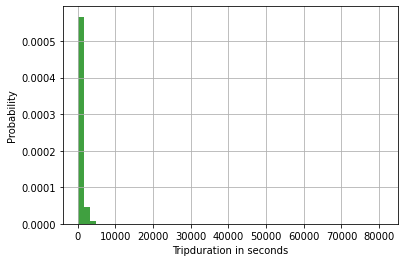

In [53]:
# histogram of the Trip_Seconds
n, bins, patches = plt.hist(df_chicago['Trip_Seconds'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripduration in seconds')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

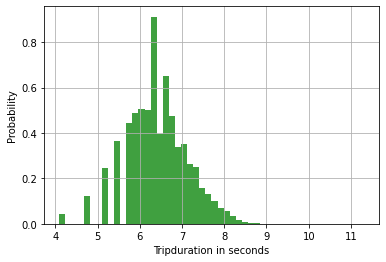

In [54]:
# histogram of the Trip_Seconds with log
n, bins, patches = plt.hist(np.log(df_chicago['Trip_Seconds']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripduration in seconds')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

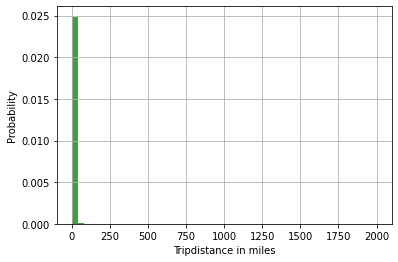

In [55]:
# histogram of the Trip_Miles
n, bins, patches = plt.hist(df_chicago['Trip_Miles'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripdistance in miles')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

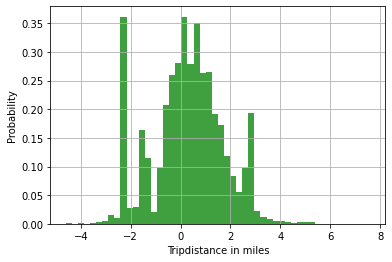

In [56]:
# histogram of the Trip_Miles with log
n, bins, patches = plt.hist(np.log(df_chicago['Trip_Miles']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Tripdistance in miles')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

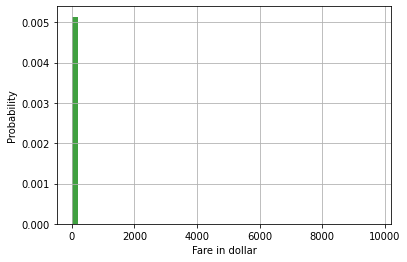

In [57]:
# histogram of the Fare
n, bins, patches = plt.hist(df_chicago['Fare'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Fare in dollar')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

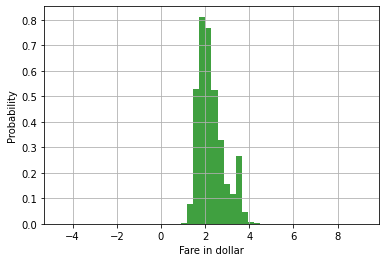

In [58]:
# histogram of the Fare with log
n, bins, patches = plt.hist(np.log(df_chicago['Fare']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Fare in dollar')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

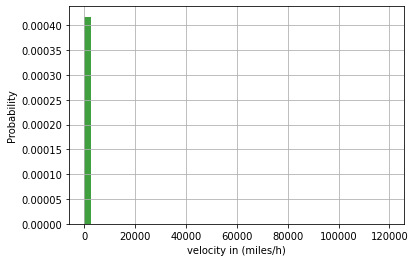

In [59]:
# histogram of the Fare
n, bins, patches = plt.hist(df_chicago['velocity_(miles/h)'], 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('velocity in (miles/h)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

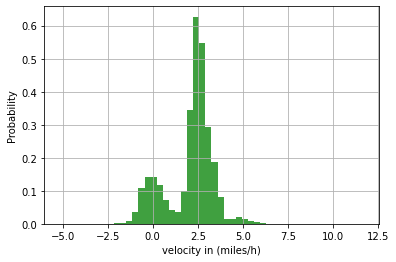

In [60]:
# histogram of the Fare with log
n, bins, patches = plt.hist(np.log(df_chicago['velocity_(miles/h)']), 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('velocity in (miles/h)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

### Remove outliers

In [61]:
from scipy.stats import zscore

def remove_outliers(df,excluded_cols=None,zscore_threshold=2,verbose=False):
    
    outlier_count = 0
    df_numeric_view = df.select_dtypes(include="number")

    for col in df_numeric_view.columns:
        if excluded_cols and col in excluded_cols:
            continue
        df[f"{col}_zscore"] = np.around(np.abs(zscore(np.log(df[col]))), decimals=1)
        outlier = df[df[f"{col}_zscore"] > zscore_threshold]
        outlier_count += outlier.shape[0]
        df.drop(outlier.index, inplace=True)
        if verbose:
            print(
                f"--> {outlier.shape[0]} outlier detected and removed from {col} column using zscore"
            )
    df = df.loc[:, ~df.columns.str.contains("zscore")]

    print(f"Outlier detection completed. Number of removed outlier: {outlier_count}")

    return df.reset_index(drop=True)

In [63]:
df_chicago = remove_outliers(df_chicago,excluded_cols=['Trip_ID','Taxi_ID','Trip_Start_Timestamp',
                            'Trip_End_Timestamp','Pickup_Census_Tract','Dropoff_Census_Tract', 
                            'Pickup_Community_Area','Dropoff_Community_Area',
                            'Payment_Type','Company','Pickup_Centroid_Latitude','Pickup_Centroid_Longitude',
                            'Pickup_Centroid_Location','Dropoff_Centroid_Latitude','Dropoff_Centroid_Longitude',
                            'Dropoff_Centroid__Location','Community_Areas','Tips','Tolls','Extras','dayOfWeek',
                            'season','isRushhour','isHoliday','date_start','start_time_hourly']
                             ,zscore_threshold=2,verbose=True)

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_zscore"] = np.around(np.abs(zscore(np.log(df[col]))), decimals=1)
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outlier.index, inplace=True)


--> 544961 outlier detected and removed from Trip_Seconds column using zscore


/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_zscore"] = np.around(np.abs(zscore(np.log(df[col]))), decimals=1)
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outlier.index, inplace=True)
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

--> 164737 outlier detected and removed from Trip_Miles column using zscore


/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outlier.index, inplace=True)


--> 693417 outlier detected and removed from Fare column using zscore


/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_zscore"] = np.around(np.abs(zscore(np.log(df[col]))), decimals=1)
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/3409631604.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outlier.index, inplace=True)


--> 509134 outlier detected and removed from velocity_(miles/h) column using zscore
Outlier detection completed. Number of removed outlier: 1912249


In [64]:
df_chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8951195 entries, 0 to 8951194
Data columns (total 30 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip_ID                     object        
 1   Taxi_ID                     object        
 2   Trip_Start_Timestamp        datetime64[ns]
 3   Trip_End_Timestamp          datetime64[ns]
 4   Trip_Seconds                float64       
 5   Trip_Miles                  float64       
 6   Pickup_Census_Tract         float64       
 7   Dropoff_Census_Tract        float64       
 8   Pickup_Community_Area       float64       
 9   Dropoff_Community_Area      float64       
 10  Fare                        float64       
 11  Tips                        float64       
 12  Tolls                       float64       
 13  Extras                      float64       
 14  Payment_Type                object        
 15  Company                     object        
 16  Pickup_Centroid_La

## Creating dataframe `df_chicago_hourly`

In [89]:
# Create temporary dataframe dfNumOfRentedBikes
df_chicago_hourly = df_chicago[["date_start", "start_time_hourly"]]
df_chicago_hourly['numOfTaxisHourly'] = 0
df_chicago_hourly.head()

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_31424/2160824547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_hourly['numOfTaxisHourly'] = 0


,date_start,start_time_hourly,numOfTaxisHourly
0,2013-01-01,0,0
1,2013-01-01,0,0
2,2013-01-01,0,0
3,2013-01-01,0,0
4,2013-01-01,0,0


In [90]:
# Calculate numOfRentedBikesHourly for each start_date & start_time_hourly
df_chicago_hourly = df_chicago_hourly.groupby(["date_start", "start_time_hourly"])['numOfTaxisHourly'].count().reset_index()
df_chicago_hourly

,date_start,start_time_hourly,numOfTaxisHourly
0,2013-01-01,0,1445
1,2013-01-01,1,1490
2,2013-01-01,2,3050
3,2013-01-01,3,1592
4,2013-01-01,4,2053
...,...,...,...
8755,2013-12-31,19,2536
8756,2013-12-31,20,4980
8757,2013-12-31,21,3145
8758,2013-12-31,22,5298


In [ ]:
# Calculate numOfRentedBikesHourly for each start_date & start_time_hourly
df_chicago_hourly = pd.merge(df_chicago_hourly, df_chicago, on=["date_start", "start_time_hourly"], how="right")

## Weather

In [ ]:
#df_Weather = pd.read_csv("https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-hourly&stations=72534014819&startDate=2013-01-01&endDate=2013-12-31&format=csv&units=metric")


In [ ]:
#df_Weather.dropna(axis=1, how = 'any')

In [ ]:
#df_Weather.info()